In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../..")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from librep.datasets.har.loaders import (
    MotionSense_BalancedView20HZ
)

2022-11-12 12:39:33.287982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-12 12:39:33.288002: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
from librep.transforms.topo_ae import (
    TopologicalDimensionalityReduction,
    CustomTopoDimRedTransform
)
from librep.transforms import UMAP
from sklearn.manifold import TSNE
from experiments.Topological_ae.Experiment_utils import *
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [6]:
# MotionSense Loader
loader = MotionSense_BalancedView20HZ(
    root_dir="../../../data/views/MotionSense/balanced_view_20Hz_with_gravity_9.81_acc_standard", 
    download=False
)

# Print the readme (optional)
loader.print_readme()

# Balanced MotionSense View Resampled to 20Hz with Gravity - Multiplied acc by 9.81m/s²

This is a view from [MotionSense] that was spllited into 3s windows and was resampled to 20Hz using the [FFT method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html#scipy.signal.resample). 

The data was first splitted in three sets: train, validation and test. Each one with the following proportions:
- Train: 70% of samples
- Validation: 10% of samples
- Test: 20% of samples

After splits, the datasets were balanced in relation to the activity code column, that is, each subset have the same number of activitiy samples.

**NOTE**: Each subset contain samples from distinct users, that is, samples of one user belongs exclusivelly to one of three subsets.

## Activity codes
- 0: downstairs (569 train, 101 validation, 170 test) 
- 1: upstairs (569 train, 101 validation, 170 test) 
- 2: sitting (569 train, 101 validation, 170 test) 
- 3: standing (569 train, 101 validation, 170 test) 
- 4: walking (569 train, 101 validation, 170 test) 
- 5: jogging (569 train, 101 validation, 170 test) 
 

## Standartized activity codes
- 0: sit (569 train, 101 validation, 170 test) 
- 1: stand (569 train, 101 validation, 170 test) 
- 2: walk (569 train, 101 validation, 170 test) 
- 3: stair up (569 train, 101 validation, 170 test) 
- 4: stair down (569 train, 101 validation, 170 test) 
- 5: run (569 train, 101 validation, 170 test) 
      




In [7]:
# Load the dataset
# If concat_train_validation is true, return a tuple (train+validation, test)
train_val, test = loader.load(concat_train_validation=True, label=loader.standard_label)
train_val, test

(PandasMultiModalDataset: samples=4020, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=1020, features=360, no. window=6, label_columns='standard activity code')

In [8]:
train_HD = np.array(train_val[:][0])
train_Y = np.array(train_val[:][1])
test_HD = np.array(test[:][0])
test_Y = np.array(test[:][1])

In [9]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(4020, 360) (4020,) (1020, 360) (1020,)


# Aplicar FFT

In [10]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(
    transforms=[fft_transform],
    new_window_name_prefix="fft."
)

In [11]:
train_dataset_fft = transformer(train_val)
test_dataset_fft = transformer(test)

In [12]:
print(train_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(4020, 180)
(1020, 180)


In [13]:
print(np.max(train_dataset_fft.X))

797.3368276806895


In [14]:
train_HD = train_dataset_fft.X
train_LD = None
train_Y = train_dataset_fft.y
test_HD = test_dataset_fft.X
test_LD = None
test_Y = test_dataset_fft.y

In [15]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(4020, 180) (4020,) (1020, 180) (1020,)


# Visualization helper

In [16]:
# 0: sit (569 train, 101 validation, 170 test)
# 1: stand (569 train, 101 validation, 170 test)
# 2: walk (569 train, 101 validation, 170 test)
# 3: stair up (569 train, 101 validation, 170 test)
# 4: stair down (569 train, 101 validation, 170 test)
# 5: run (569 train, 101 validation, 170 test)
def visualize(X, Y):
    labels = ['sit', 'stand', 'walk', 'stair up', 'stair down', 'run']
    df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
    groups = df.groupby('label')
    fig, ax = plt.subplots()
    ax.margins(0.05)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='.', linestyle='', ms=8, label=labels[name])
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [17]:
# Variables to reuse
model_dim = 10
model_epc = 500

# Reducing with Generic Autoencoders

In [18]:
model_lam = 0
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim2
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:766.5261, Loss-ae:766.5261, Loss-topo:163.5084
Epoch:2, P:None, Loss:392.3043, Loss-ae:392.3043, Loss-topo:417.0863
Epoch:3, P:None, Loss:360.0556, Loss-ae:360.0556, Loss-topo:453.0189
Epoch:4, P:None, Loss:330.0118, Loss-ae:330.0118, Loss-topo:480.9212
Epoch:5, P:None, Loss:319.2059, Loss-ae:319.2059, Loss-topo:632.3731
Epoch:6, P:None, Loss:300.2042, Loss-ae:300.2042, Loss-topo:677.3215
Epoch:7, P:None, Loss:304.9918, Loss-ae:304.9918, Loss-topo:807.1224
Epoch:8, P:None, Loss:296.3962, Loss-ae:296.3962, Loss-topo:842.5396
Epoch:9, P:None, Loss:251.2738, Loss-ae:251.2738, Loss-topo:1177.5416
Epoch:10, P:None, Loss:229.2521, Loss-ae:229.2521, Loss-topo:1567.2324
Epoch:11, P:None, Loss:207.8630, Loss-ae:207.8630, Loss-topo:1617.9776
Epoch:12, P:None, Loss:202.3897, Loss-ae:202.3897, Loss-topo:1827.4611
Epoch:13, P:None, Loss:205.1755, Loss-ae:205.1755, Loss-topo:1881.0189
Epoch:14, P:None, Loss:193.8736, Loss-ae:193.8736, Loss-topo:2194.6090
Epoch:15, P:None, Loss:

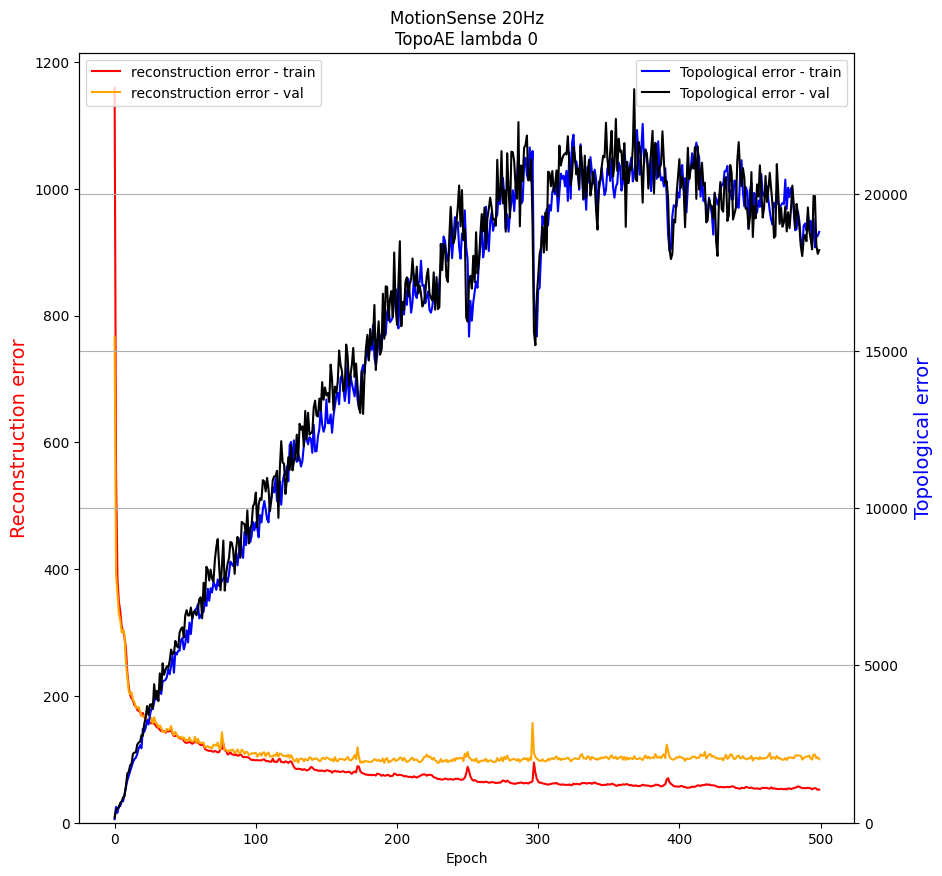

In [19]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [20]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [21]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [22]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8896078431372547,
 'RF-F1': 0.8888639514129373,
 'SVC-ACC': 0.8872549019607843,
 'SVC-F1': 0.887724946206416,
 'KNN-ACC': 0.8343137254901961,
 'KNN-F1': 0.8339524689976289}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


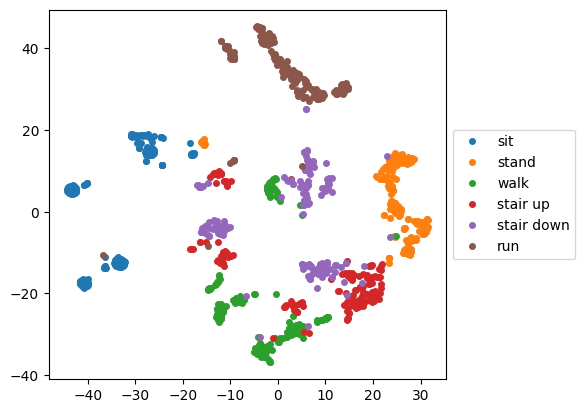

In [23]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=1)

In [24]:
model_lam = 1
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim2
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:763.4464, Loss-ae:740.2950, Loss-topo:23.1514
Epoch:2, P:None, Loss:686.9621, Loss-ae:681.9389, Loss-topo:5.0232
Epoch:3, P:None, Loss:709.6293, Loss-ae:704.2622, Loss-topo:5.3671
Epoch:4, P:None, Loss:679.3311, Loss-ae:674.8064, Loss-topo:4.5247
Epoch:5, P:None, Loss:436.6416, Loss-ae:422.2082, Loss-topo:14.4334
Epoch:6, P:None, Loss:362.3991, Loss-ae:354.1609, Loss-topo:8.2382
Epoch:7, P:None, Loss:343.5731, Loss-ae:337.2044, Loss-topo:6.3687
Epoch:8, P:None, Loss:328.3820, Loss-ae:322.9756, Loss-topo:5.4064
Epoch:9, P:None, Loss:321.1342, Loss-ae:315.6229, Loss-topo:5.5113
Epoch:10, P:None, Loss:316.5552, Loss-ae:310.7866, Loss-topo:5.7687
Epoch:11, P:None, Loss:309.1374, Loss-ae:303.7084, Loss-topo:5.4290
Epoch:12, P:None, Loss:296.0383, Loss-ae:291.4260, Loss-topo:4.6123
Epoch:13, P:None, Loss:295.8001, Loss-ae:291.1639, Loss-topo:4.6362
Epoch:14, P:None, Loss:320.8995, Loss-ae:314.9707, Loss-topo:5.9288
Epoch:15, P:None, Loss:284.3109, Loss-ae:279.4973, Loss

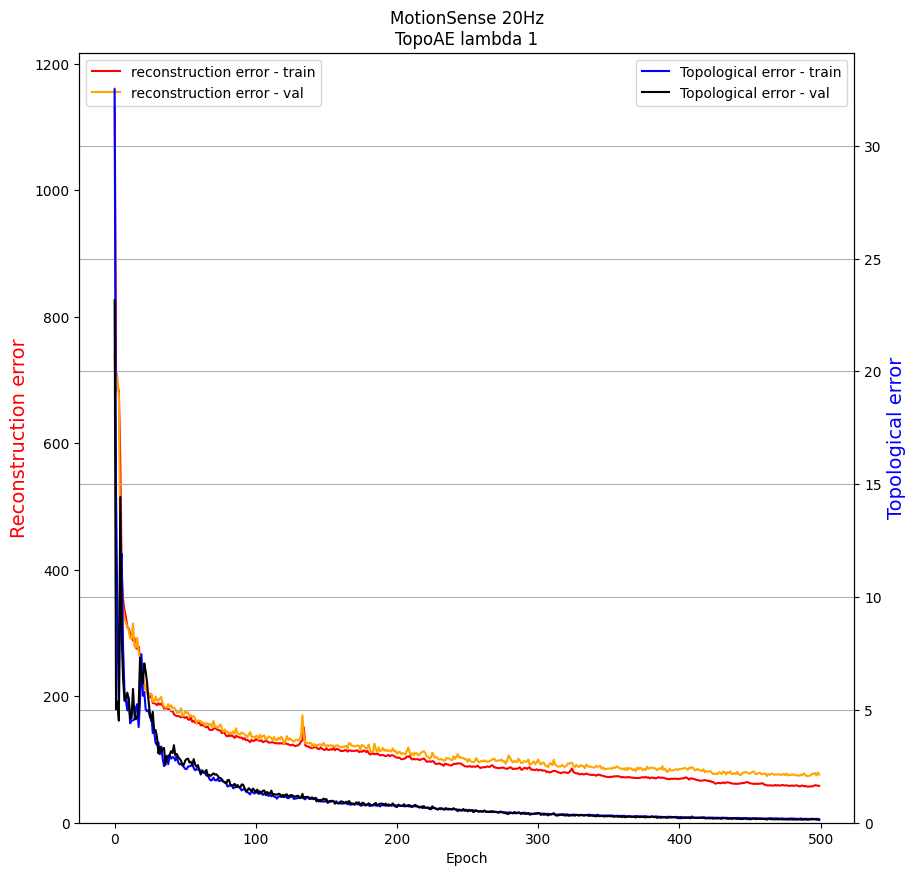

In [25]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [26]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [27]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [28]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8380392156862746,
 'RF-F1': 0.8386491961982244,
 'SVC-ACC': 0.8901960784313725,
 'SVC-F1': 0.8898129399379141,
 'KNN-ACC': 0.8274509803921568,
 'KNN-F1': 0.8272090238209435}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


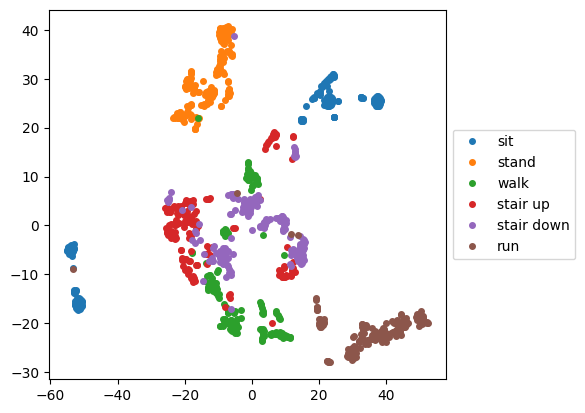

In [29]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=5)

In [30]:
model_lam = 5
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim2
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:852.7291, Loss-ae:816.1884, Loss-topo:7.3081
Epoch:2, P:None, Loss:741.5422, Loss-ae:726.6040, Loss-topo:2.9876
Epoch:3, P:None, Loss:707.1558, Loss-ae:703.8180, Loss-topo:0.6676
Epoch:4, P:None, Loss:702.2791, Loss-ae:696.5723, Loss-topo:1.1414
Epoch:5, P:None, Loss:683.8006, Loss-ae:678.0414, Loss-topo:1.1518
Epoch:6, P:None, Loss:478.6999, Loss-ae:466.7934, Loss-topo:2.3813
Epoch:7, P:None, Loss:386.6429, Loss-ae:374.4079, Loss-topo:2.4470
Epoch:8, P:None, Loss:380.1346, Loss-ae:372.0840, Loss-topo:1.6101
Epoch:9, P:None, Loss:362.7957, Loss-ae:356.8255, Loss-topo:1.1941
Epoch:10, P:None, Loss:365.2296, Loss-ae:359.0550, Loss-topo:1.2349
Epoch:11, P:None, Loss:343.8559, Loss-ae:338.7387, Loss-topo:1.0234
Epoch:12, P:None, Loss:361.0591, Loss-ae:356.8208, Loss-topo:0.8477
Epoch:13, P:None, Loss:341.0645, Loss-ae:336.3911, Loss-topo:0.9347
Epoch:14, P:None, Loss:333.7987, Loss-ae:329.2650, Loss-topo:0.9067
Epoch:15, P:None, Loss:331.5101, Loss-ae:327.3235, Loss-t

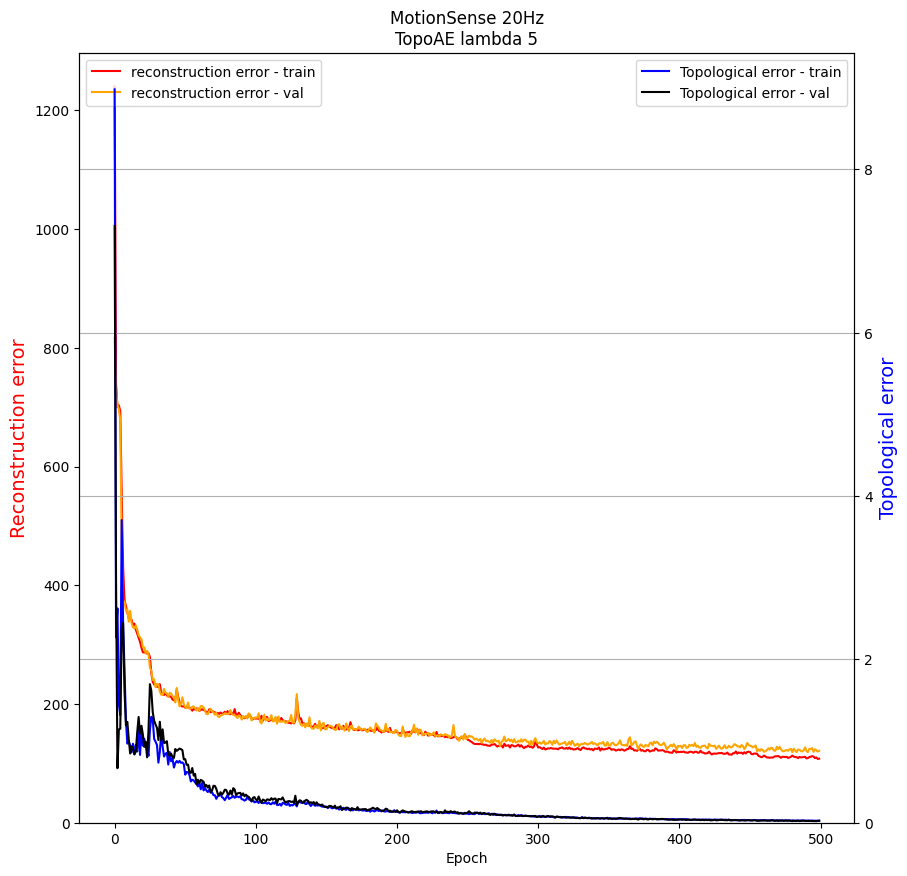

In [31]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [32]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [33]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [34]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8577450980392157,
 'RF-F1': 0.860498028601504,
 'SVC-ACC': 0.8960784313725491,
 'SVC-F1': 0.896237583881264,
 'KNN-ACC': 0.8392156862745098,
 'KNN-F1': 0.8393903834579558}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


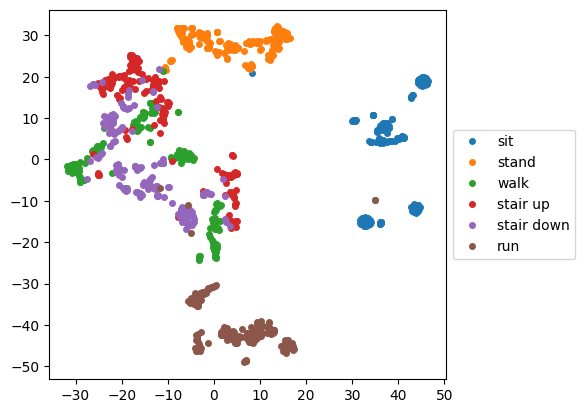

In [35]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=10)

In [36]:
model_lam = 10
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim2
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:825.3705, Loss-ae:805.9034, Loss-topo:1.9467
Epoch:2, P:None, Loss:724.6366, Loss-ae:712.9174, Loss-topo:1.1719
Epoch:3, P:None, Loss:732.3521, Loss-ae:725.0695, Loss-topo:0.7283
Epoch:4, P:None, Loss:696.9570, Loss-ae:691.2281, Loss-topo:0.5729
Epoch:5, P:None, Loss:706.1753, Loss-ae:702.1531, Loss-topo:0.4022
Epoch:6, P:None, Loss:676.1187, Loss-ae:672.2946, Loss-topo:0.3824
Epoch:7, P:None, Loss:700.7177, Loss-ae:695.8810, Loss-topo:0.4837
Epoch:8, P:None, Loss:536.5790, Loss-ae:518.9045, Loss-topo:1.7675
Epoch:9, P:None, Loss:380.0867, Loss-ae:370.2221, Loss-topo:0.9865
Epoch:10, P:None, Loss:376.8407, Loss-ae:367.5190, Loss-topo:0.9322
Epoch:11, P:None, Loss:341.9789, Loss-ae:335.4704, Loss-topo:0.6509
Epoch:12, P:None, Loss:327.1523, Loss-ae:322.2558, Loss-topo:0.4897
Epoch:13, P:None, Loss:320.7167, Loss-ae:315.3735, Loss-topo:0.5343
Epoch:14, P:None, Loss:324.5591, Loss-ae:319.8308, Loss-topo:0.4728
Epoch:15, P:None, Loss:311.3756, Loss-ae:306.4897, Loss-t

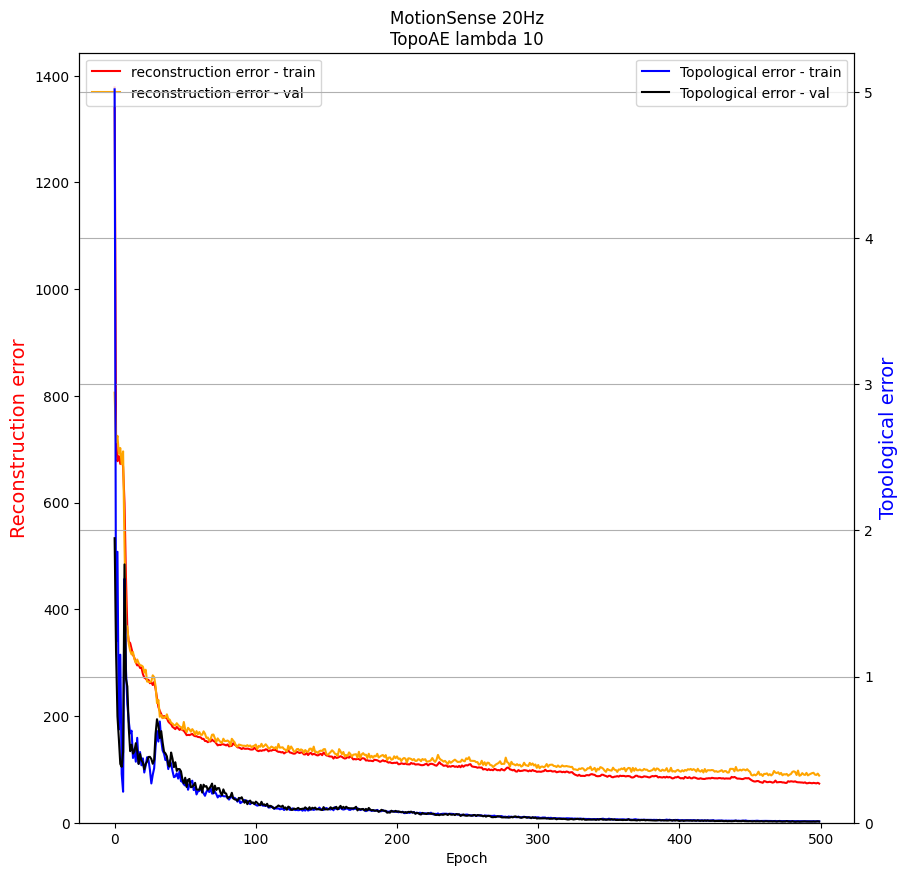

In [37]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [38]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [39]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [40]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8702941176470589,
 'RF-F1': 0.8672181991844647,
 'SVC-ACC': 0.9196078431372549,
 'SVC-F1': 0.919816133876414,
 'KNN-ACC': 0.8058823529411765,
 'KNN-F1': 0.8016376596226361}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


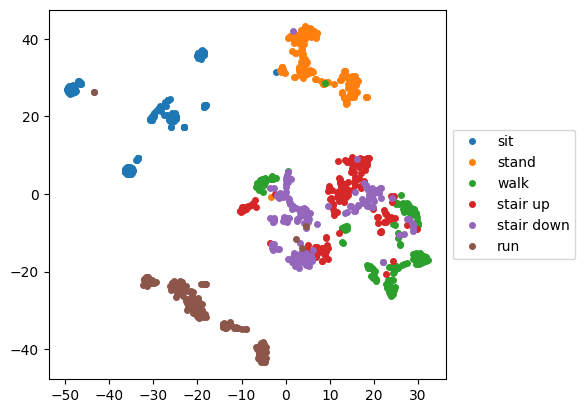

In [41]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=100)

In [42]:
model_lam = 100
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim2
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:892.8894, Loss-ae:851.0750, Loss-topo:0.4181
Epoch:2, P:None, Loss:790.9097, Loss-ae:778.4470, Loss-topo:0.1246
Epoch:3, P:None, Loss:789.5362, Loss-ae:778.6016, Loss-topo:0.1093
Epoch:4, P:None, Loss:814.5815, Loss-ae:810.7310, Loss-topo:0.0385
Epoch:5, P:None, Loss:732.8992, Loss-ae:725.8795, Loss-topo:0.0702
Epoch:6, P:None, Loss:734.7658, Loss-ae:731.9942, Loss-topo:0.0277
Epoch:7, P:None, Loss:713.9157, Loss-ae:710.1284, Loss-topo:0.0379
Epoch:8, P:None, Loss:734.1784, Loss-ae:731.0977, Loss-topo:0.0308
Epoch:9, P:None, Loss:714.6819, Loss-ae:712.0420, Loss-topo:0.0264
Epoch:10, P:None, Loss:719.9760, Loss-ae:717.7193, Loss-topo:0.0226
Epoch:11, P:None, Loss:694.1585, Loss-ae:675.9982, Loss-topo:0.1816
Epoch:12, P:None, Loss:475.1344, Loss-ae:469.0507, Loss-topo:0.0608
Epoch:13, P:None, Loss:410.6741, Loss-ae:405.3819, Loss-topo:0.0529
Epoch:14, P:None, Loss:391.5079, Loss-ae:385.2216, Loss-topo:0.0629
Epoch:15, P:None, Loss:388.0906, Loss-ae:385.1058, Loss-t

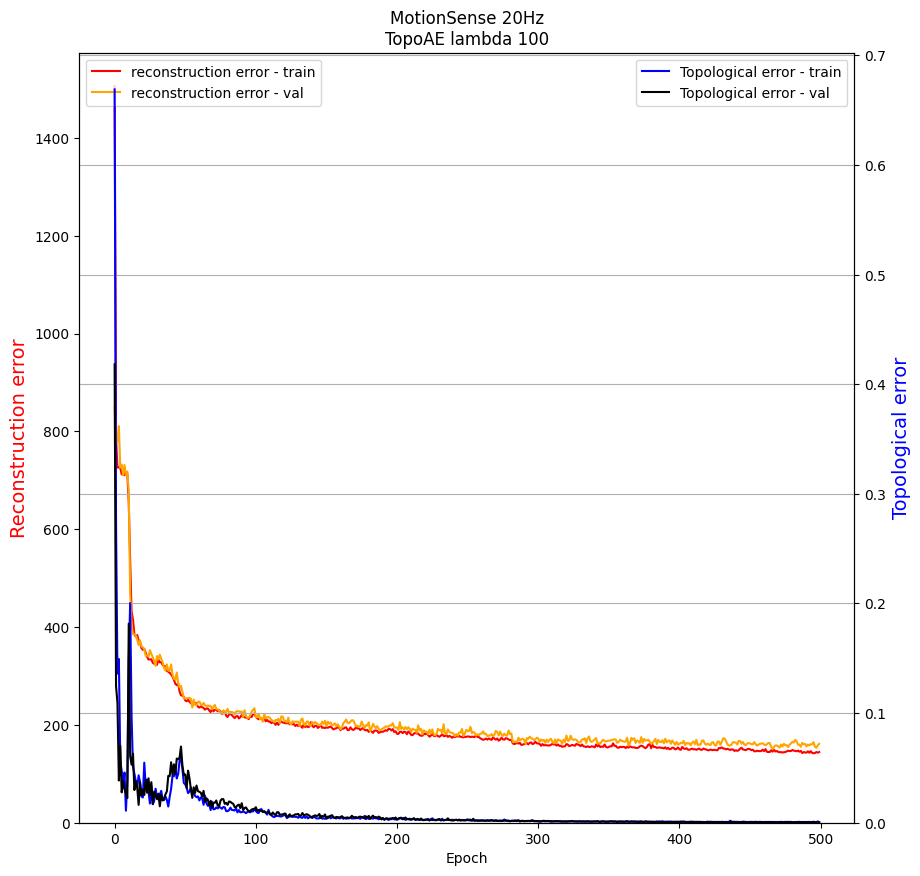

In [43]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [44]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [45]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [46]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8741176470588234,
 'RF-F1': 0.8739867511318298,
 'SVC-ACC': 0.9009803921568628,
 'SVC-F1': 0.9019738813004106,
 'KNN-ACC': 0.8549019607843137,
 'KNN-F1': 0.8544403263788372}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


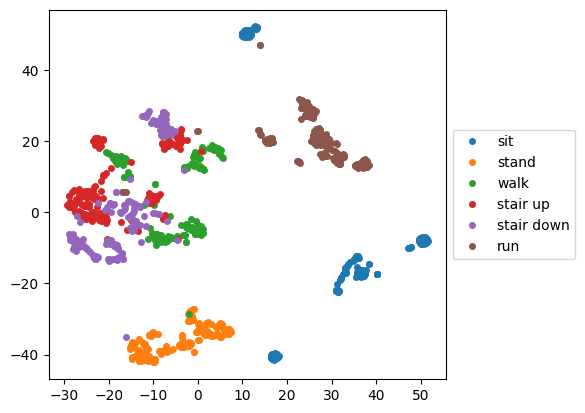

In [47]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

In [48]:
# Reducing with Convolutional Topological Autoencoders

In [49]:
# model_lam = 1
# model_dim = 10
# model_epc = 200
# topo_reducer = TopologicalDimensionalityReduction(
#     ae_model='ConvolutionalAutoencoder_custom_dim',
#     lam = model_lam,
#     ae_kwargs = {'input_dims':(1, 360), 'custom_dim':model_dim},
#     input_shape = (-1, 1, 1, 360),
#     patience = None,
#     num_epochs = model_epc
# )

In [50]:
# title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
# topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [51]:
# train_LD = topo_reducer.transform(train_HD)
# test_LD = topo_reducer.transform(test_HD)

In [52]:
# train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
# print('TRAIN LD RESHAPED', train_LD.shape)
# test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
# print('TEST LD RESHAPED', test_LD.shape)

In [53]:
# experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
# experiments_result